In [1]:
# Draw the simulation environmnt
# Draw sequencing and reach-avoid task
# dynamic model 
# draw a success rate table

In [2]:
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
import gym
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import Dataset
import sys
from collect_skill_trajectories import get_all_goal_value, from_real_dict_to_vector, ZONE_OBS_DIM
from stable_baselines3 import PPO
from train_dynamics import VFDynamics, VFDynamicsMLP
import rtamt
import time
#from gym.wrappers import RecordVideo
from gym.wrappers.monitor import video_recorder as VR
import math
from tqdm import tqdm
sys.path.append("/app/vfstl/src/GCRL-LTL/zones")
from envs import ZoneRandomGoalEnv
from envs.utils import get_zone_vector
from rl.traj_buffer import TrajectoryBufferDataset
import matplotlib.pyplot as plt
from PIL import Image

/opt/conda/envs/myenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("CUDA is available. Training on GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Training on CPU.")

def cost_fn(state):
    return torch.randn(state.size()[0])

model_path = '/app/vfstl/src/GCRL-LTL/zones/models/goal-conditioned/best_model_ppo_4'
policy_model = PPO.load(model_path, device=device)
timeout = 1000
env = ZoneRandomGoalEnv(
    env=gym.make('Zones-8-v0', timeout=timeout), 
    primitives_path='/app/vfstl/src/GCRL-LTL/zones/models/primitives', 
    goals_representation=get_zone_vector(),
    use_primitves=True,
    rewards=[0, 1],
    device=device,
)

CUDA is available. Training on GPU.


In [4]:
obs = env.reset()

In [5]:
rgb_array = env.render(mode='rgb_array', camera_id=1, width=1920, height=1080)

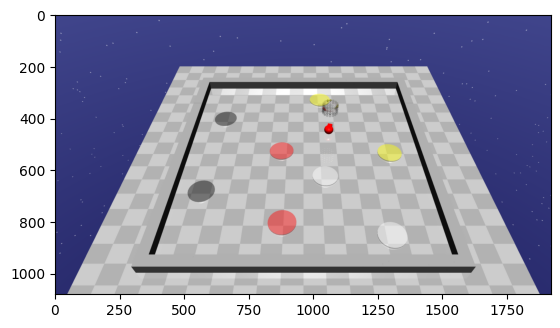

In [6]:
plt.imshow(rgb_array)

In [7]:
im = Image.fromarray(rgb_array)
im.save("/app/vfstl/src/VFSTL/data_for_paper/simulation_env_3.jpeg")